## Set up environment

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
#import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [35]:
print(keras.__version__)
tf.__version__

2.1.4


'1.2.1'

In [36]:
# get a GPU session and reserve memory
def get_session(gpu_fraction=0.3):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session(.90))

In [37]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [38]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [39]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [40]:
np.random.seed(123)

# Vars and HPs

In [41]:
# Set hyper parameters
original_dim = 300000
latent_dim = 100

batch_size = 50
epochs = 50
learning_rate = 0.0005

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1

# Load methylation data

In [42]:
methyl_file = os.path.join('data', 'TCGA_BRCA_top300kMAD_cpg.tsv')
methyl_df = pd.read_table(methyl_file, index_col=0)
print(methyl_df.shape)
methyl_df.head(5)

KeyboardInterrupt: 

In [43]:
# Reduce the data size for model testing
methyl_df2 = methyl_df.sample(original_dim, axis=1) # this is not correct when real training happens
print(methyl_df2.shape)
methyl_df2.head(5)

(862, 300000)


,cg00122254,cg07950803,cg06020352,cg00014104,cg04108240,cg19537719,cg11461670,cg26282887,cg18552413,cg05595753,...,cg22089024,cg23289779,cg01870834,cg00901843,cg25934198,cg13688262,cg14428878,cg18131582,cg12917938,cg06904956
7796806090_R04C01,0.046660,0.897248,0.652521,0.471406,0.775688,0.495734,0.438540,0.510294,0.561539,0.768544,...,0.060164,0.723294,0.398821,0.503005,0.702736,0.774951,0.841170,0.559773,0.806210,0.840528
6285633051_R04C01,0.058873,0.486256,0.352591,0.427361,0.913327,0.720762,0.484323,0.535114,0.266286,0.819594,...,0.061524,0.670289,0.478324,0.467078,0.809887,0.867867,0.642287,0.583485,0.865380,0.864694
9993943017_R04C02,0.079432,0.445756,0.789767,0.570244,0.837710,0.218656,0.302884,0.661226,0.326385,0.817745,...,0.044401,0.408273,0.727590,0.559788,0.910760,0.746987,0.413313,0.767292,0.848849,0.871472
7796806090_R03C01,0.056591,0.854925,0.496990,0.185658,0.882997,0.061131,0.026978,0.659007,0.429860,0.613741,...,0.024281,0.458832,0.648874,0.380753,0.772982,0.680736,0.818467,0.505687,0.859446,0.842765
3999997079_R01C02,0.053748,0.178044,0.853712,0.174643,0.885674,0.067699,0.559529,0.728681,0.143848,0.749181,...,0.036990,0.318999,0.757237,0.473694,0.719295,0.830167,0.351490,0.192757,0.834724,0.857373


In [44]:
# Split 10% test set randomly
test_set_percent = 0.1
methyl_test_df = methyl_df2.sample(frac=test_set_percent)
methyl_train_df = methyl_df2.drop(methyl_test_df.index)

# Encoder

In [45]:
# Input place holder for methylation data with specific input size
methyl_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
# and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the methyl input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# Decoder

In [46]:
# The decoding layer is much simpler with a single layer glorot uniform initialized and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
methyl_reconstruct = decoder_to_reconstruct(z)

# Encoder + Decoder = VAE

In [47]:
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([methyl_input, methyl_reconstruct])
vae = Model(methyl_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300000)       0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 100)          30000100    input_3[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 100)          30000100    input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 100)          400         dense_7[0][0]                    
__________________________________________________________________________________________________
batch_norm

C:\Users\atitus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_3" during training.
  after removing the cwd from sys.path.


In [48]:
# Visualize the connections of the custom VAE model
output_model_file = os.path.join('figures', 'onehidden_vae_architecture.eps')
plot_model(vae, to_file=output_model_file)

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

# Train the model

In [49]:
%%time
hist = vae.fit(np.array(methyl_train_df),
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(np.array(methyl_test_df), np.array(methyl_test_df)),
               callbacks=[WarmUpCallback(beta, kappa)])

ValueError: ('Error when checking model target: expected no data, but got:', array([[ 0.03308689,  0.82624223,  0.54685273, ...,  0.78407808,
         0.87457004,  0.81861516],
       [ 0.02959353,  0.43862998,  0.41818635, ...,  0.54273541,
         0.83594015,  0.84685494],
       [ 0.06567254,  0.67192673,  0.28095218, ...,  0.59994095,
         0.88507839,  0.81780314],
       ..., 
       [ 0.06619068,  0.64890409,  0.67049138, ...,  0.69258406,
         0.87349869,  0.8943042 ],
       [ 0.07569845,  0.29401364,  0.28774711, ...,  0.76286033,
         0.90091877,  0.91070668],
       [ 0.04509313,  0.8756331 ,  0.44706674, ...,  0.59246953,
         0.83751562,  0.83921123]]))

In [50]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('figures', 'onehidden_vae_training_300K-100.pdf') 
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_30K-1000.pdf') 
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_100K-10.pdf')
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_100K-100.pdf')
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_10K-100.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

NameError: name 'hist' is not defined

# Compile and output models

## Encoder

In [19]:
# Model to compress input
encoder = Model(methyl_input, z_mean_encoded)

In [20]:
# Encode methyl into the hidden/latent representation - and save output
encoded_methyl_df = encoder.predict_on_batch(methyl_df2)
encoded_methyl_df = pd.DataFrame(encoded_methyl_df, index=methyl_df2.index)

encoded_methyl_df.columns.name = 'sample_id'
encoded_methyl_df.columns = encoded_methyl_df.columns + 1
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100K-10.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100K-100.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_10K-100.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_300K-1000.tsv')
encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_300K-100.tsv')
encoded_methyl_df.to_csv(encoded_file, sep='\t')

In [21]:
# What are the most and least activated nodes
top_active_nodes = encoded_methyl_df.sum(axis=0).sort_values(ascending=False)
print(top_active_nodes.head(10))
top_active_nodes.tail(10)

sample_id
72    2689.523682
19    2261.734619
3     2233.960938
52    2158.137939
76    1944.653687
66    1915.777466
78    1817.843872
55    1793.530273
39    1703.847656
64    1642.765991
dtype: float32


sample_id
88    98.864792
43    89.600433
40    73.793655
25    70.327644
93    68.710793
97    66.469162
51    40.531780
89    37.308762
45    21.683561
42    19.556742
dtype: float32

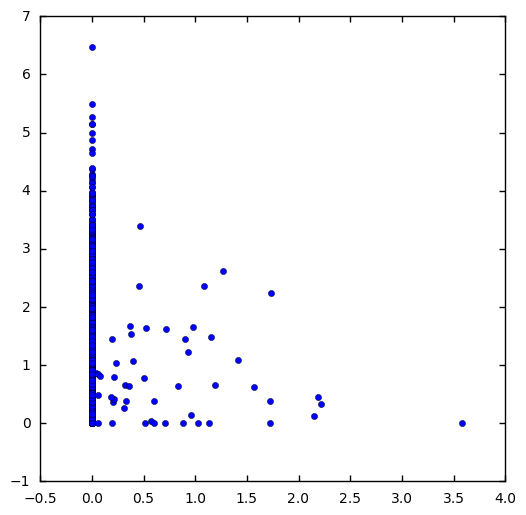

In [24]:
# Example distribution of latent layer
plt.figure(figsize=(6, 6))
plt.scatter(encoded_methyl_df.iloc[:, 50], encoded_methyl_df.iloc[:, 8])

## Decoder

In [25]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

In [26]:
# How well does the model reconstruct the input Methylation data
input_methyl_reconstruct = decoder.predict(np.array(encoded_methyl_df))
input_methyl_reconstruct = pd.DataFrame(input_methyl_reconstruct, index=methyl_df2.index,
                                        columns=methyl_df2.columns)
input_methyl_reconstruct.head(3)

,cg05609218,cg22931085,cg17251874,cg15207619,cg18069268,cg11787508,cg13337949,cg04485516,cg01828530,cg09648722,...,ch.9.1173620F,cg04300684,cg16770054,cg18900959,cg14847845,cg23107916,cg16751754,cg15457745,cg00849943,cg17289222
7796806090_R04C01,0.672033,0.876269,0.767542,0.123064,0.973082,0.764291,0.045026,0.967063,0.780857,0.039814,...,0.037846,0.606236,0.931593,0.926697,0.860495,0.698333,0.932990,0.022119,0.015452,0.980561
6285633051_R04C01,0.729906,0.843547,0.671565,0.059589,0.977977,0.790845,0.022084,0.983528,0.836831,0.024214,...,0.022224,0.636163,0.962394,0.942780,0.848625,0.553571,0.961438,0.012269,0.008690,0.993206
9993943017_R04C02,0.693098,0.843114,0.466781,0.036274,0.960945,0.771037,0.029470,0.975914,0.902240,0.032599,...,0.041737,0.697151,0.967159,0.921050,0.807059,0.539523,0.965884,0.018012,0.019237,0.994381


In [27]:
print(methyl_df2.shape)
methyl_df2.head(3)

(862, 300000)


,cg05609218,cg22931085,cg17251874,cg15207619,cg18069268,cg11787508,cg13337949,cg04485516,cg01828530,cg09648722,...,ch.9.1173620F,cg04300684,cg16770054,cg18900959,cg14847845,cg23107916,cg16751754,cg15457745,cg00849943,cg17289222
7796806090_R04C01,0.545441,0.853057,0.649835,0.259499,0.938481,0.526505,0.128962,0.884376,0.770399,0.100277,...,0.087824,0.487777,0.875961,0.873091,0.874440,0.653986,0.917380,0.047611,0.044446,0.699034
6285633051_R04C01,0.664495,0.821738,0.551126,0.240213,0.934988,0.462401,0.070426,0.943853,0.624185,0.087996,...,0.103713,0.509940,0.838878,0.896937,0.679916,0.429626,0.762457,0.037634,0.033631,0.976383
9993943017_R04C02,0.592440,0.777425,0.292605,0.178106,0.571350,0.886400,0.125322,0.867190,0.750185,0.094839,...,0.157848,0.600940,0.918040,0.833179,0.676394,0.380983,0.903616,0.041686,0.049972,0.901056


In [ ]:
#methylation_out_file = os.path.join('data', 'TCGA_BRCA_30kgenerated_cpg.tsv')
methylation_out_file = os.path.join('data', 'TCGA_BRCA_300kgenerated_cpg_100latent.tsv')
methyl_df2.to_csv(methylation_out_file, sep='\t')

In [ ]:
#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_100K-10.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_100K-10.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_100K-100.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_100K-100.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_10K-100.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_10K-100.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_30K-1000.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_30K-1000.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_300K-1000.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_300K-1000.hdf5')

encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_300K-100.hdf5')
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_300K-100.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)